In [86]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import torch
from lib.library import cost_matrix_d

### load the original fish data, add noise. 

In [87]:

def toNp(X):
    return X.data.cpu().numpy()

def scale_fish(fishin, k=.65):
    '''Scale the fish by a factor of k'''
    return k * fishin

def make_noise(fishin,p,k=2):
    '''
    Add p% noise to a k-dim fish
    '''
    N = len(fishin)
    noise = np.random.uniform(low=-1.5,high=1.5,size=(int(N*p/100),2))
    fishout = np.concatenate((fishin, noise))
    return noise, fishout

def reduce_fish(fishin, p):
    '''
    Reduce p% points from input fish
    '''
    n = int(len(fishin) * p / 100)
    ind = np.random.choice(len(fishin), n, replace=False)
    fishout = np.delete(fishin, ind, axis = 0)
    return fishout

### Optimal Transport Calculations:

- C32, C54, etc., are distance matrices between different fish shapes.
- p32, p54, etc., are the optimal transport plans that minimize the cost of moving points from one shape to another.
- fish3hat2, fish5hat4, etc., are the transformed shapes after the application of Optimal Transport.
- Partial Optimal Transport is also used in some cases (pp54, pp58) to perform a soft-matching between shapes.

In [98]:
fish1 = np.loadtxt("data/fish_source.txt") #distorted fish
fish2 = np.loadtxt("data/fish_target.txt") #original fish
fish3 = scale_fish(fish2) #mini fish

noise4, fish4 = make_noise(fish2, 20) #noisy fish

fish5 = scale_fish(fish2)
noise5, fish5 = make_noise(fish5, 20) #noisy scaled fish
fish6 = reduce_fish(fish5, 40) #noisy scaled reduced

fish7 = reduce_fish(fish2, 40) #clean fish with points destroyed
fish8 = scale_fish(fish7) #scaled reduced
noise9, fish9 = make_noise(fish7, 20) #noisy reduced


In [99]:
# fish1 = torch.from_numpy(fish1).type(torch.FloatTensor) #distorted
# fish2 = torch.from_numpy(fish2).type(torch.FloatTensor) #original
# fish3 = torch.from_numpy(fish3).type(torch.FloatTensor) #original scaled
# fish4 = torch.from_numpy(fish4).type(torch.FloatTensor) #Noisy
# fish5 = torch.from_numpy(fish5).type(torch.FloatTensor) #Noisy scaled
# fish6 = torch.from_numpy(fish6).type(torch.FloatTensor) #Noisy scaled reduced
# fish7 = torch.from_numpy(fish7).type(torch.FloatTensor) #original reduced
# fish8 = torch.from_numpy(fish8).type(torch.FloatTensor) #scaled reduced
# fish9 = torch.from_numpy(fish9).type(torch.FloatTensor) #noisy reduced

N1 = fish1.shape[0]
N2 = fish2.shape[0]
N3 = fish3.shape[0]
N4 = fish4.shape[0]
N5 = fish5.shape[0]
N6 = fish6.shape[0]
N7 = fish7.shape[0]
N8 = fish8.shape[0]
N9 = fish9.shape[0]


a2 = np.ones(N2)/float(N2)
a3 = np.ones(N3)/float(N3)
a4 = np.ones(N4)/float(N4)
a5 = np.ones(N5)/float(N5)
a6 = np.ones(N6)/float(N6)
a7 = np.ones(N7)/float(N7)
a8 = np.ones(N8)/float(N8)
a9 = np.ones(N9)/float(N9)


In [100]:
#Axes 0
#From original scaled (3) to original (2)
C23 = ot.dist(fish2, fish3)
p23 = ot.emd(a2,a3,C23)
p1_hat=np.sum(p23,1)
Domain=p1_hat>1e-10
fish3hat2=p23.dot(fish3)[Domain]/np.expand_dims(p1_hat,1)[Domain]


In [101]:
C45 = ot.dist(fish4, fish5)
p45 = ot.emd(a4, a5, C45)
a4_1,a5_1=np.ones_like(a4),np.ones_like(a5)

pp45 = ot.partial.partial_wasserstein(a4_1,a5_1,C45,m=N2)
p1_hat=np.sum(p45,1)
Domain=p1_hat>1e-10
fish5hat4=p45.dot(fish5)[Domain]/np.expand_dims(p1_hat,1)[Domain]
ind1 = np.argwhere(pp45.sum(1)).squeeze()
ind2 = np.argmax(pp45[ind1,:],1).squeeze()

# fish5hat4 = np.dot((N4*p54).T,fish5)


In [102]:
C82 = ot.dist(fish8, fish2)
p82 = ot.emd(a8,a2,C82)
a8_1,a2_1=np.ones_like(a8),np.ones_like(a2)
pp82 = ot.partial.partial_wasserstein(a8_1,a2_1,C82,m=N7)
p1_hat=np.sum(p82,1)
Domain=p1_hat>1e-10
barry82=p82.dot(fish2)[Domain]/np.expand_dims(p1_hat,1)[Domain]
ind182 = np.argwhere(pp82.sum(1)).squeeze()
ind282 = np.argmax(pp82[ind182,:],1).squeeze()

In [103]:
#Axes 4
#From noisy scaled reduced to noisy original
C64 = ot.dist(fish6, fish4)
p64 = ot.emd(a6, a4, C64)
p1_hat=np.sum(p64,1)
Domain=p1_hat>1e-10
fish6hat4=p64.dot(fish4)[Domain]/np.expand_dims(p1_hat,1)[Domain]

#fish6hat4 = np.matmul((N4*p64).T,fish6)
barry64 = fish6hat4.copy() #np.matmul(N6*p64,fish4)


In [104]:
a6_1,a4_1=np.ones_like(a6),np.ones_like(a4)
pp64=ot.partial.partial_wasserstein(a6_1,a4_1,C64,m=N6)
ind3=np.argwhere(pp64.sum(1)).squeeze()
ind4=np.argmax(pp64[ind3,:],1).squeeze()

p1_hat=np.sum(pp64,1)
Domain=p1_hat>1e-10
barry64_1=pp64.dot(fish4)[Domain]/np.expand_dims(p1_hat,1)[Domain]

In [107]:
a64 = np.ones(barry64_1.shape[0])/float(barry64_1.shape[0])
a64_1 = np.ones(barry64_1.shape[0])
CC = ot.dist(fish6, barry64_1)
pp=ot.partial.partial_wasserstein(a6_1,a64_1,CC,m=N6)
ind5=np.argwhere(pp.sum(1)).squeeze()
ind6=np.argmax(pp[ind5,:],1).squeeze()

### Visualization of OT, OPT and Barycentric projection

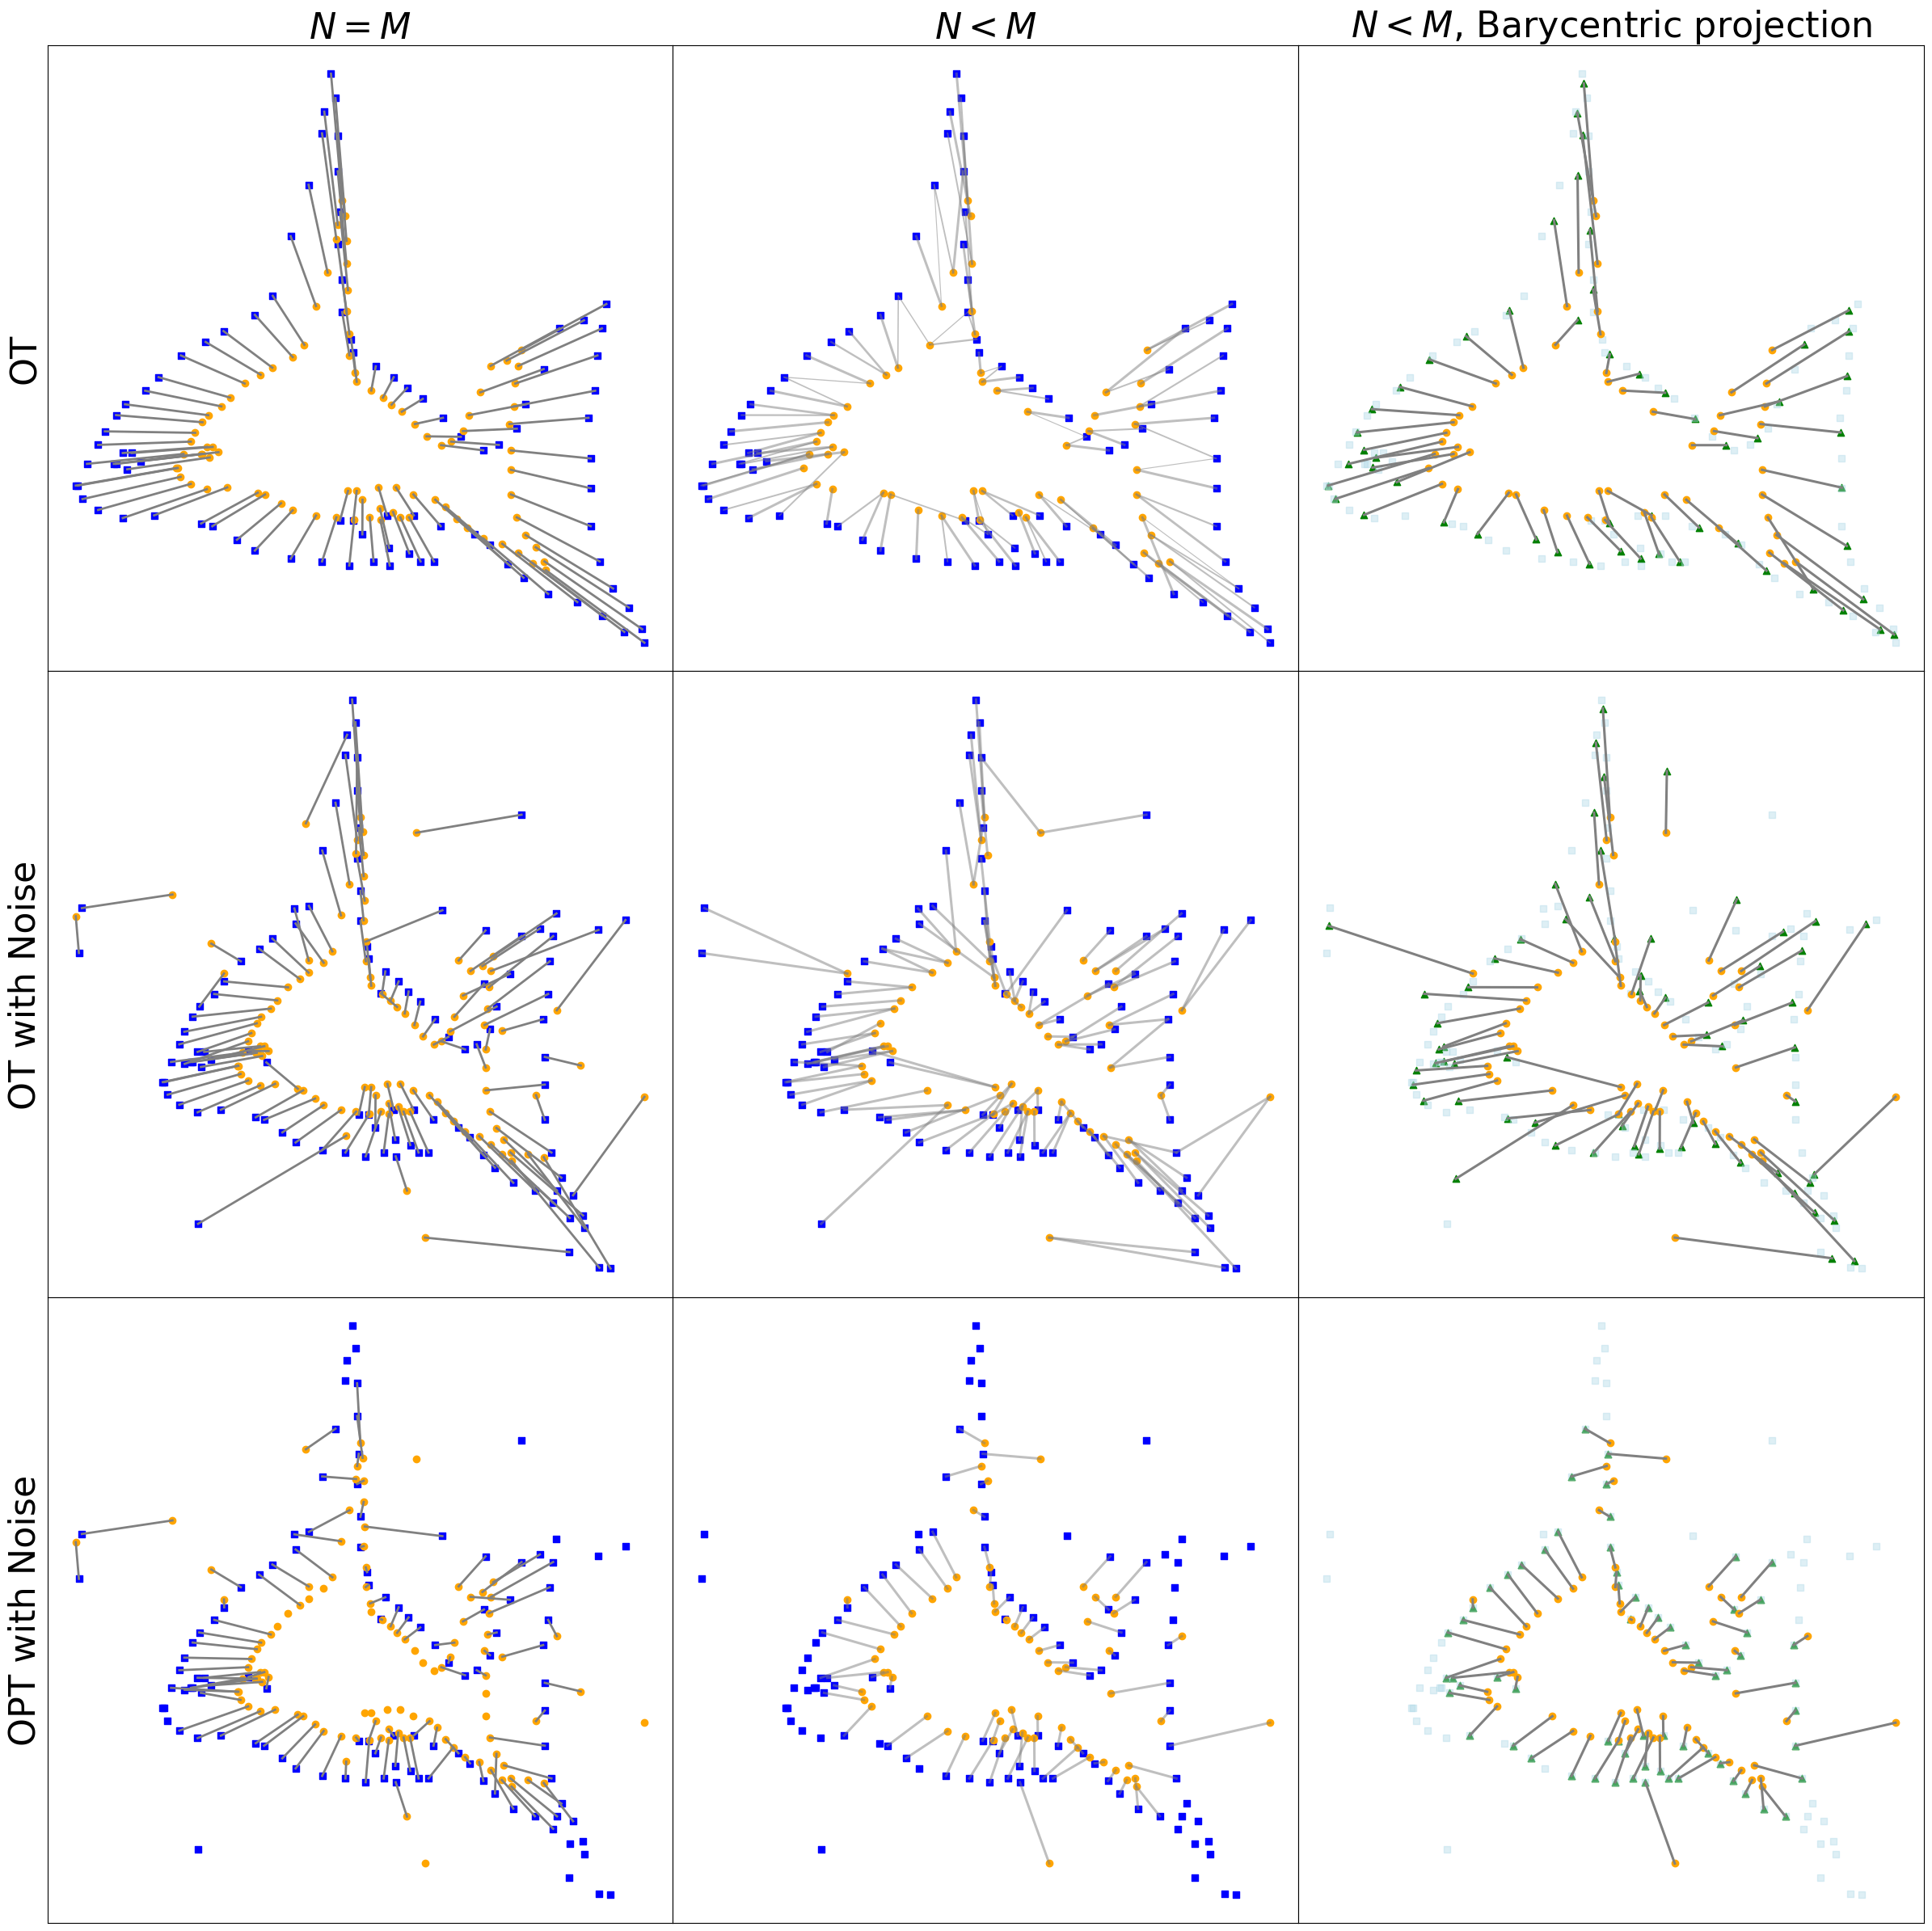

In [123]:
thres = 4e-3
max_lw=200
fig, axes = plt.subplots(3,3, figsize=(24,24), gridspec_kw={'wspace': 0, 'hspace': 0})
axes = axes.flatten()
lw=2.0
for i in range(len(axes)):
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

y_axis_labels = ['OT', 'OT with Noise', 'OPT with Noise']
for i in range(3):
    axes[i * 3].set_ylabel(y_axis_labels[i], fontsize=32)

'''Organized vertically'''
    
'''First column'''
#Axes 0: Original scaled (3) to original (2) using OT
axes[0].set_title('$N=M$', fontsize=32)
axes[0].scatter(fish2[:,0], fish2[:,1], marker='s',color='blue') #Original
axes[0].scatter(fish3hat2[:,0], fish3hat2[:,1],color='orange') #Scale
for i in range(len(fish2)):
    axes[0].plot([fish2[i,0],fish3hat2[i,0]],[fish2[i,1],fish3hat2[i,1]], c='gray', lw=lw)

#Axes 3: Noisy scaled (5) to Noisy (4) using OT
axes[3].scatter(fish4[:,0], fish4[:,1], marker='s',color='blue') #Noisy
axes[3].scatter(fish5hat4[:,0], fish5hat4[:,1],color='orange') #Noisy scaled
for i in range(len(fish4)):
    axes[3].plot([fish4[i,0],fish5hat4[i,0]],[fish4[i,1],fish5hat4[i,1]], c='gray', lw=lw)

#Axes 6: Noisy scaled to Noisy using OPT
#axes[6].set_title('$N=M$', fontsize=40)
axes[6].scatter(fish4[:,0], fish4[:,1], marker='s',color='blue')
axes[6].scatter(fish5[:,0], fish5[:,1],color='orange')
for i,j in zip(ind1,ind2):
    axes[6].plot([fish4[i,0],fish5[j,0]],[fish4[i,1],fish5[j,1]], c='gray', lw=lw)

'''Second column'''
#Axes 1:  Original scaled (3) to original reduced (6) using OT
axes[1].set_title('$N < M$', fontsize=32)
axes[1].scatter(fish2[:,0], fish2[:,1], marker='s',color='blue') #Original reduced
axes[1].scatter(fish8[:,0], fish8[:,1],color='orange') #Original scaled
for i in range(fish8.shape[0]):
    for j in range(fish2.shape[0]):
        if p82[i,j] > thres:
            lw = p82[i,j] * max_lw
            axes[1].plot([fish8[i,0],fish2[j,0]],[fish8[i,1],fish2[j,1]], c='gray', lw=lw, alpha=.5)

#Axes 4: Noisy scaled (5) to Noisy reduced (8) using OT
#axes[4].set_title('$N < M$', fontsize=40)
axes[4].scatter(fish4[:,0], fish4[:,1], marker='s',color='blue')
axes[4].scatter(fish6[:,0], fish6[:,1],color='orange')
for i in range(fish6.shape[0]):
    for j in range(fish4.shape[0]):
        if p64[i,j] > thres:
            # lw = p64[i,j] * max_lw
            axes[4].plot([fish6[i,0],fish4[j,0]],[fish6[i,1],fish4[j,1]], c='gray', lw=lw, alpha=.5)

#Axes 7: Noisy scaled (5) to Noisy reduced (8) using OPT
#axes[7].set_title('$N < M$', fontsize=40)
axes[7].scatter(fish4[:,0], fish4[:,1], marker='s',color='blue')
axes[7].scatter(fish6[:,0], fish6[:,1],color='orange')
for i in range(fish6.shape[0]):
    for j in range(fish4.shape[0]):
        if pp64[i,j] > thres:
            # lw = pp64[i,j] * max_lw/N7
            axes[7].plot([fish6[i,0],fish4[j,0]],[fish6[i,1],fish4[j,1]], c='gray', lw=lw, alpha=.5)

'''Third column'''
#Axes 2: Original caled (3) to original reduced (6) using barrycentric proj
axes[2].set_title('$N < M$, Barycentric projection', fontsize=32)
axes[2].scatter(barry82[:,0], barry82[:,1], marker='^',color='green')
axes[2].scatter(fish2[:,0], fish2[:,1], marker='s',color='lightblue',alpha=.4) #Original
axes[2].scatter(fish8[:,0], fish8[:,1],color='orange') #Scale
for i in range(len(barry82)):
    axes[2].plot([fish8[i,0],barry82[i,0]],[fish8[i,1],barry82[i,1]], c='gray', lw=lw)

#Axes 5: noisy scaled (5) to noisy reduced (8) using barrycentric proj
#axes[5].set_title('$N < M$, Barycentric projection', fontsize=40)
axes[5].scatter(barry64[:,0], barry64[:,1], marker='^',color='green') #Original
axes[5].scatter(fish4[:,0], fish4[:,1], marker='s',color='lightblue',alpha=.4) #Original
axes[5].scatter(fish6[:,0], fish6[:,1],color='orange') #Scale
for i in range(len(barry64)):
    axes[5].plot([barry64[i,0],fish6[i,0]],[barry64[i,1],fish6[i,1]], c='gray', lw=lw)


#Axes 8: noisy caled (5) to noisy reduced (8) using barrycentric proj
#axes[8].set_title('$N < M$, Barycentric projection', fontsize=40)
axes[8].scatter(barry64_1[:,0], barry64_1[:,1], marker='^',color='green') #Original
axes[8].scatter(fish4[:,0], fish4[:,1], marker='s',color='lightblue',alpha=.4) #Original
axes[8].scatter(fish6[:,0], fish6[:,1],color='orange') #Scale
for i,j in zip(ind5,ind6):
    axes[8].plot([fish6[i,0],barry64_1[j,0]],[fish6[i,1],barry64_1[j,1]], c='gray', lw=lw)
    
plt.tight_layout()    
plt.savefig('results/fish_figures.pdf',bbox_inches='tight')    
plt.show()


In [115]:
lw

3.6363636363636362

In [61]:
# thres = 4e-3
# max_lw=200
# fig, axes = plt.subplots(1,3, figsize=(24,7))
# axes = axes.flatten()

# for i in range(len(axes)):
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
#     axes[i].set_xticklabels([])
#     axes[i].set_yticklabels([])

# '''Organized vertically'''
    
# '''First column'''
# # #Axes 0: Original scaled (3) to original (2) using OT
# # axes[0].set_title('$N=M$', fontsize=20)
# # axes[0].scatter(fish2[:,0], fish2[:,1], marker='s') #Original
# # axes[0].scatter(fish3[:,0], fish3[:,1]) #Scale
# # for i in range(len(fish2)):
# #     axes[0].plot([fish2[i,0],fish3hat2[i,0]],[fish2[i,1],fish3hat2[i,1]], c='gray', lw=1)

# #Axes 3: Noisy scaled (5) to Noisy (4) using OT
# # axes[0].set_title('$N=M$', fontsize=20)
# # axes[0].scatter(fish4[:,0], fish4[:,1], marker='s') #Noisy
# # axes[0].scatter(fish5[:,0], fish5[:,1]) #Noisy scaled
# # for i in range(len(fish4)):
# #     axes[0].plot([fish4[i,0],fish5hat4[i,0]],[fish4[i,1],fish5hat4[i,1]], c='gray', lw=1)

# # #Axes 6: Noisy scaled to Noisy using OPT
# axes[0].set_title('$N=M$', fontsize=20)
# axes[0].scatter(fish3[:,0], fish3[:,1], marker='s')
# axes[0].scatter(fish2[:,0], fish2[:,1])
# for i,j in zip(ind132,ind232):
#     axes[0].plot([fish3[i,0],fish2[j,0]],[fish3[i,1],fish2[j,1]], c='gray', lw=.5)

# # '''Second column'''
# #Axes 1:  Original scaled (3) to original reduced (6) using OT
# # axes[1].set_title('$N < M$', fontsize=20)
# # axes[1].scatter(fish2[:,0], fish2[:,1], marker='s') #Original reduced
# # axes[1].scatter(fish8[:,0], fish8[:,1]) #Original scaled
# # for i in range(fish8.shape[0]):
# #     for j in range(fish2.shape[0]):
# #         if p82[i,j] > thres:
# #             lw = p82[i,j] * max_lw
# #             axes[1].plot([fish8[i,0],fish2[j,0]],[fish8[i,1],fish2[j,1]], c='gray', lw=lw, alpha=.5)

# # #Axes 4: Noisy scaled (5) to Noisy reduced (8) using OT
# # axes[1].set_title('$N < M$', fontsize=20)
# # axes[1].scatter(fish4[:,0], fish4[:,1], marker='s')
# # axes[1].scatter(fish6[:,0], fish6[:,1])
# # for i in range(fish6.shape[0]):
# #     for j in range(fish4.shape[0]):
# #         if p64[i,j] > thres:
# #             lw = p64[i,j] * max_lw
# #             axes[1].plot([fish6[i,0],fish4[j,0]],[fish6[i,1],fish4[j,1]], c='gray', lw=lw, alpha=.5)

# # #Axes 7: Noisy scaled (5) to Noisy reduced (8) using OPT
# axes[1].set_title('$N < M$', fontsize=20)
# axes[1].scatter(fish2[:,0], fish2[:,1], marker='s')
# axes[1].scatter(fish8[:,0], fish8[:,1])
# for i in range(fish8.shape[0]):
#     for j in range(fish2.shape[0]):
#         if pp82[i,j] > thres:
#             lw = pp82[i,j] * max_lw
#             axes[1].plot([fish8[i,0],fish2[j,0]],[fish8[i,1],fish2[j,1]], c='gray', lw=lw, alpha=.5)

# # '''Third column'''
# #Axes 2: Original caled (3) to original reduced (6) using barrycentric proj
# # axes[2].set_title('$N < M$, Barycentric projection', fontsize=20)
# # axes[2].scatter(barry82[:,0], barry82[:,1], marker='^')
# # axes[2].scatter(fish2[:,0], fish2[:,1], marker='s',color='lightblue',alpha=.4) #Original
# # axes[2].scatter(fish8[:,0], fish8[:,1]) #Scale
# # for i in range(len(barry82)):
# #     axes[2].plot([fish8[i,0],barry82[i,0]],[fish8[i,1],barry82[i,1]], c='gray', lw=.5)

# # #Axes 5: noisy scaled (5) to noisy reduced (8) using barrycentric proj
# # axes[2].set_title('$N < M$, Barycentric projection', fontsize=20)
# # axes[2].scatter(barry64[:,0], barry64[:,1], marker='^') #Original
# # axes[2].scatter(fish4[:,0], fish4[:,1], marker='s',color='lightblue',alpha=.4) #Original
# # axes[2].scatter(fish6[:,0], fish6[:,1]) #Scale
# # for i in range(len(barry64)):
# #     axes[2].plot([barry64[i,0],fish6[i,0]],[barry64[i,1],fish6[i,1]], c='gray', lw=.5)


# # #Axes 8: noisy caled (5) to noisy reduced (8) using barrycentric proj
# axes[2].set_title('$N < M$, Barycentric projection', fontsize=20)
# axes[2].scatter(barry82[:,0], barry82[:,1], marker='^') #Original
# axes[2].scatter(fish2[:,0], fish2[:,1], marker='s',color='lightblue',alpha=.4) #Original
# axes[2].scatter(fish8[:,0], fish8[:,1]) #Scale
# for i,j in zip(ind582,ind682):
#     axes[2].plot([fish8[i,0],barry82[j,0]],[fish8[i,1],barry82[j,1]], c='gray', lw=.5)
    
    
# plt.savefig('fig4.pdf',bbox_inches='tight')    
# plt.show()
